# Introduction

Basically any NN that we use today, like chatGPT, claude, etc... has a really big MLP inside, for example in GPT2 we have that roughly 70% of the params are in the MLP.

MLP's are based on the Universal Approximation Theorem, that states that the family of Neural Networks is dense in the space of continuous functions. Which means that we can approximate any continuous function with a MLP.

**Theorem**:Universal Approximation Theorem (On continuous functions)

Given a function space $F$ of continuous functions on a compact set $K$ and a function $f \in F$ and $\epsilon > 0$ there exists a MLP $g$ such that:
$$ \sup_{x \in K} |f(x) - g(x)| < \epsilon $$


That's great and it works fine since we have all those LLM's and other NNs that we use today.

But the theorem doesn't say anything about the number of parameters of the network, so we can have really big networks with a lot of parameters to approximate a function. (GPT4o has north of 100 trillion parameters according to AX-Semantics)

Let's try to find something that can approximate functions with a lot less parameters.

# KAN Network

## Theory
KAN network are based on the Kolmogorov-Arnold theorem, which states that any multivariable continuous function can be written as a finite composition of continuous functions of a single variable.

#### Theorem:
Given a continuous function $f:[0,1]^n \rightarrow \mathbb{R}$, there exist continuous functions $\phi_{q,p}:[0,1] \rightarrow \mathbb{R}$ and $\Phi_q:\mathbb{R} \rightarrow \mathbb{R}$ such that:
$$ f(x_1,x_2,...,x_n) = \sum_{q=1}^{2n+1} \Phi_q(\sum_{p=1}^{n}\phi_{q,p}(x_p)) \hspace{3cm} (\ast)$$  

This has a simple consequence: the only "true" multivariable function is the sum

That would be great for ML, we just said that every continuous function can be written as a sum of continuous functions of a single variable.
But we didn't give any regularity (except for the continuity of the functions) on the functions $\phi$ and $\phi$, we can have very bad functions, like Takagi curve or the Cantor function.
The first is always continuous but nowhere differentiable, the second is differentiable almost everywhere but its derivative is 0 almost everywhere but is monotonically non-decreasing.

<table style="width: 100%;">
  <tr>
    <th>Funzione di Takagi</th>
    <th>Funzione di Cantor</th>
  </tr>
  <tr>
    <td style="text-align: center;">
      <img src="https://user-images.githubusercontent.com/47231909/68320138-513a1e80-00b7-11ea-9f59-054fee300527.png" alt="Funzione di Takagi" width="90%">
    </td>
    <td style="text-align: center;">
      <img src="https://upload.wikimedia.org/wikipedia/commons/1/14/CantorFunction.png" alt="Funzione di Cantor" width="90%">
    </td>
  </tr>
</table>

However, if we generalize the Representation Theorem with more layers and more dimensions and we make the assumption that most functions in science and daily life are often smooth and have sparse compositional structures, we facilitate the smooth K-A representation.



## KAN Architecture

Suppose we have $ \{\mathbf{x}_i, y_i\}_{i\leq N} $ and we want to find a function $f$ such that $f(\mathbf{x}_i) \approx y_i$ $ \forall i$.

If we are able to find every $\phi_{q,p}$ and $\Phi_q$ we are done.

Since we made the assumption that we want just "good" functions to approximate and every $ \phi_{q,p} $ and $ \Phi_q $ are univariate we parametrize each function with a B-spline where the learning parameters are the coefficients of the B-spline.




## What are B-splines?

B-splines (Basis Splines) are a series of piecewise-defined polynomial functions that are used in numerical and computational methods to create smooth curves. They are constructed by joining multiple polynomial segments, which are defined on specific intervals (called knots). B-splines have several useful properties:

1.	Local control: Adjusting the control points of the B-spline affects only the local segments, allowing fine-grained curve control without impacting the entire shape.
2.	Smoothness: The degree of continuity between segments can be specified, allowing for smooth transitions.
3.	Flexibility: By adjusting the degree of the polynomial, B-splines can represent simple to complex shapes, from linear to higher-order curves.

They are widely used in fields like computer graphics, data fitting, and numerical analysis for tasks such as curve fitting, surface modeling, and even machine learning applications due to their computational efficiency and flexibility.

### Digression: B-Splines
#### B-Splines: Definition and Key Results

B-splines (Basis splines) are piecewise polynomial functions that form a basis for spline spaces of a certain degree over a given interval partitioned by knots. They are fundamental in approximation theory, computer graphics, CAD/CAM, and numerical analysis for modeling smooth curves and surfaces.

#### Definition

A B-spline of degree $k$ is defined recursively using a non-decreasing sequence of knots $ t_0, t_1, \dots, t_{n+k+1} $:

1. **Basis Function for $k = 0 $**:

   $$
   N_{i,0}(t) =
   \begin{cases}
   1, & \text{if } t_i \leq t < t_{i+1} \\
   0, & \text{otherwise}
   \end{cases}
   $$

2. **Recursive Definition for $k \geq 1 $**:

   $$
   N_{i,k}(t) = \frac{t - t_i}{t_{i+k} - t_i} N_{i,k-1}(t) + \frac{t_{i+k+1} - t}{t_{i+k+1} - t_{i+1}} N_{i+1,k-1}(t)
   $$

   where divisions by zero are defined to be zero.

#### Properties

- **Non-negativity**: $N_{i,k}(t) \geq 0 $ for all $t $.

- **Compact Support**: $N_{i,k}(t) $ is non-zero only on the interval $[t_i, t_{i+k+1}) $.

- **Partition of Unity**:

  $$
  \sum_{i=0}^{n} N_{i,k}(t) = 1, \quad \text{for all } t \in [t_k, t_{n+1}]
  $$

- **Continuity**: B-splines of degree $k $ are $C^{k-1} $ continuous over the open intervals between knots, assuming knots are not repeated.

- **Local Modification**: Adjusting a control point affects the curve only within the span of the corresponding basis function.

#### Important Theorems

##### Theorem 1: De Boor's Algorithm

**Hypotheses**:

- A B-spline curve $C(t) $ of degree $k $ defined by control points $\{ P_i \} $ and a non-decreasing knot vector $\{ t_i \} $.
- A parameter value $t $ within the valid domain $[t_k, t_{n+1}] $.

**Conclusion**:

The value of the B-spline curve at $t $, denoted $C(t) $, can be efficiently computed using De Boor's algorithm, which performs a sequence of recursive computations.

**Explanation**:

De Boor's algorithm evaluates $C(t) $ by iteratively computing intermediate points:

1. **Initialization**: Set $d_i^0 = P_i $ for $i = j - k $ to $j $, where $j $ is the index such that $t_j \leq t < t_{j+1} $.

2. **Recursion**:

   For $r = 1 $ to $k $:
   
   $$
   d_i^r = (1 - \alpha_i^r) d_{i-1}^{r-1} + \alpha_i^r d_i^{r-1}
   $$
   
   where
   
   $$
   \alpha_i^r = \frac{t - t_i}{t_{i+k-r+1} - t_i}
   $$
   
3. **Result**: The curve value at $t $ is $C(t) = d_{j}^{k} $.

This algorithm is numerically stable and generalizes the de Casteljau algorithm used for Bézier curves.

##### Theorem 2: Variation Diminishing Property

**Hypotheses**:

- A B-spline curve $C(t) $ defined using control points $\{ P_i \} $ and corresponding basis functions $N_{i,k}(t) $.
- A hyperplane $H $ in the Euclidean space.

**Conclusion**:

The number of times the B-spline curve $C(t) $ crosses the hyperplane $H $ does not exceed the number of times the control polygon $\{ P_i \} $ crosses $H $.

**Explanation**:

This property ensures that B-spline curves do not introduce additional oscillations compared to the control polygon, preserving the shape characteristics and ensuring smoothness without unwanted wiggles.

##### Theorem 3: Linear Independence of B-Spline Basis Functions

**Hypotheses**:

- B-spline basis functions $\{ N_{i,k}(t) \} $ defined over a knot vector with non-decreasing knots and without excessive knot multiplicities.

**Conclusion**:

The set $\{ N_{i,k}(t) \} $ is linearly independent on the interval $(t_k, t_{n+1}) $.

**Explanation**:

No B-spline basis function in the set can be represented as a linear combination of the others within the specified interval. This linear independence is crucial for ensuring uniqueness in spline representations and for solving interpolation and approximation problems.

##### Theorem 4: Smoothness at Knots

**Hypotheses**:

- A B-spline curve of degree $k $ with a knot vector $\{ t_i \} $ where each knot $t_i $ has multiplicity $m_i $.

**Conclusion**:

The B-spline curve is $C^{k - m_i} $ continuous at knot $t_i $.

**Explanation**:

- **Simple Knots** ($m_i = 1 $): The curve is $C^{k-1} $ continuous at $t_i $.
- **Multiple Knots**: Each additional knot multiplicity reduces the continuity by one degree.
- **Effect**: Knot multiplicity allows control over the smoothness of the curve at specific points, which is useful for creating sharp corners or cusps when necessary.

##  Applications

- **Computer-Aided Design (CAD)**: Designing automotive bodies, aircraft surfaces, and consumer product shapes.
- **Computer Graphics**: Rendering smooth curves and surfaces in 3D modeling and animation.
- **Data Approximation**: Fitting smooth curves to experimental data in statistics and data analysis.
- **Signal Processing**: Representing and analyzing signals using spline functions.

#### Advantages of B-Splines

- **Local Control**: Changes to control points or knots affect only the local region of the curve.
- **Flexibility**: Capable of representing complex shapes with a high degree of smoothness.
- **Numerical Stability**: Algorithms like De Boor's are stable and efficient for evaluation.
- **Reduced Computational Cost**: Due to their local support, B-splines are computationally efficient for large-scale problems.
- **Smoothness Control**: The degree and knot multiplicities allow precise control over the curve's continuity.

---

**References**:

- **C. de Boor**, *A Practical Guide to Splines*, Springer-Verlag, 2001.
- **L. Piegl and W. Tiller**, *The NURBS Book*, Springer-Verlag, 1997.
- **E. Cohen, R. Riesenfeld, G. Elber**, *Geometric Modeling with Splines: An Introduction*, A. K. Peters, 2001.


As it is the Representation Theorem $(\ast)$ is too simple to approximate any function, we need to add some layers to the network.

But first we have to define what is a layer in a KAN network.

Let's think about a layer in a MLP: a layer in a MLP is a linear trasformation with a non-linear activation function applied element-wise.

<svg width="1000" height="600">
  <!-- Strato di input -->
  <!-- Neuroni di input con valori -->
  <circle cx="100" cy="150" r="30" fill="#87CEFA"/>
  <text x="100" y="155" font-size="14" text-anchor="middle" fill="#000">x₁=0.5</text>
  
  <circle cx="100" cy="300" r="30" fill="#87CEFA"/>
  <text x="100" y="305" font-size="14" text-anchor="middle" fill="#000">x₂=0.8</text>
  
  <circle cx="100" cy="450" r="30" fill="#87CEFA"/>
  <text x="100" y="455" font-size="14" text-anchor="middle" fill="#000">x₃=0.2</text>

  <!-- Connessioni dagli input alla matrice dei pesi W₁ -->
  <line x1="130" y1="150" x2="200" y2="150" stroke="#ccc"/>
  <line x1="130" y1="300" x2="200" y2="300" stroke="#ccc"/>
  <line x1="130" y1="450" x2="200" y2="450" stroke="#ccc"/>

  <!-- Matrice dei pesi W₁ -->
  <rect x="200" y="100" width="80" height="400" fill="#F0E68C" stroke="#000"/>
  <text x="240" y="90" font-size="16" text-anchor="middle" fill="#000">W₁</text>

  <!-- Connessioni dalla matrice W₁ alle funzioni di attivazione ReLU -->
  <line x1="280" y1="150" x2="360" y2="150" stroke="#ccc"/>
  <line x1="280" y1="300" x2="360" y2="300" stroke="#ccc"/>
  <line x1="280" y1="450" x2="360" y2="450" stroke="#ccc"/>

  <!-- Funzioni di attivazione ReLU -->
  <rect x="360" y="120" width="80" height="60" fill="#FFD700" rx="10" ry="10"/>
  <text x="400" y="155" font-size="14" text-anchor="middle" fill="#000">ReLU</text>

  <rect x="360" y="270" width="80" height="60" fill="#FFD700" rx="10" ry="10"/>
  <text x="400" y="305" font-size="14" text-anchor="middle" fill="#000">ReLU</text>

  <rect x="360" y="420" width="80" height="60" fill="#FFD700" rx="10" ry="10"/>
  <text x="400" y="455" font-size="14" text-anchor="middle" fill="#000">ReLU</text>

  <!-- Connessioni dalle ReLU ai neuroni dello strato nascosto -->
  <line x1="440" y1="150" x2="510" y2="150" stroke="#ccc"/>
  <line x1="440" y1="300" x2="510" y2="300" stroke="#ccc"/>
  <line x1="440" y1="450" x2="510" y2="450" stroke="#ccc"/>

  <!-- Neuroni dello strato nascosto -->
  <circle cx="510" cy="150" r="30" fill="#90EE90"/>
  <text x="510" y="155" font-size="14" text-anchor="middle" fill="#000">h₁</text>
  
  <circle cx="510" cy="300" r="30" fill="#90EE90"/>
  <text x="510" y="305" font-size="14" text-anchor="middle" fill="#000">h₂</text>
  
  <circle cx="510" cy="450" r="30" fill="#90EE90"/>
  <text x="510" y="455" font-size="14" text-anchor="middle" fill="#000">h₃</text>

  <!-- Connessioni dai neuroni nascosti alla matrice dei pesi W₂ -->
  <line x1="540" y1="150" x2="610" y2="300" stroke="#ccc"/>
  <line x1="540" y1="300" x2="610" y2="300" stroke="#ccc"/>
  <line x1="540" y1="450" x2="610" y2="300" stroke="#ccc"/>

  <!-- Matrice dei pesi W₂ -->
  <rect x="610" y="270" width="80" height="60" fill="#F0E68C" stroke="#000"/>
  <text x="650" y="265" font-size="16" text-anchor="middle" fill="#000">W₂</text>

  <!-- Connessione dalla matrice W₂ alla funzione di attivazione ReLU -->
  <line x1="690" y1="300" x2="760" y2="300" stroke="#ccc"/>

  <!-- Funzione di attivazione ReLU per l'output -->
  <rect x="760" y="270" width="80" height="60" fill="#FFD700" rx="10" ry="10"/>
  <text x="800" y="305" font-size="14" text-anchor="middle" fill="#000">ReLU</text>

  <!-- Connessione dalla ReLU al neurone di output -->
  <line x1="840" y1="300" x2="900" y2="300" stroke="#ccc"/>

  <!-- Neurone di output -->
  <circle cx="900" cy="300" r="30" fill="#FF7F7F"/>
  <text x="900" y="305" font-size="14" text-anchor="middle" fill="#000">y</text>
</svg>

Or we can write any layer mathematically as:
$$ h_j = \sigma(W_j x + b_j) $$
where $W_j$ is the weight matrix, $b_j$ is the bias vector and $\sigma$ is the activation function.


## What is a KAN layer?

a KAN layer with $n_{in}$-dimensional inputs and $n_{out}$-dimensional outputs can be defined as a matrix of 1D functions 
$$ \mathbf{\Phi}=\{ {\phi_{q,p}}\} \hspace{1cm} q=1,2,...,n_{out} \hspace{1cm} p=1,2,...,n_{in} $$
Where each $\phi_{q,p}$ is a B-spline of degree k that has trainable coefficients.


We can see that in the Representation Theorem $(*)$ we have 2 layers:
1. the first takes in n inputs and gives 2n+1 outputs
2. the second takes in 2n+1 inputs and gives 1 output

So now it becomes clear that a deeper KAN is just a KAN with more layers.


## KAN architecture

Now we define the shape of a KAN network simply as:
$$[n_0,n_1,n_2,...,n_L]$$
where $n_i$ is the number of nodes on the $i$-th layer.

We denote the $i^{th}$ neuron in the $l^{th}$ layer as $(l,i)$ and the activation value of th $(l,i)$-neuron as $x_{l,i}$.

Between layer $l$ and layer $l+1$ we have $n_l*n_{l+1}$ activation functions and the activation function that connects $(l,i)$ and $(l+1,j)$ is denoted by 
$$\phi_{l,j,i} \hspace{1cm}l=0,...,L-1 \hspace{1cm} i=1,...,n_l \hspace{1cm} j=1,...,n_{l+1}$$


The pre-activation of $\phi_{l,j,i}$ is just $x_{l,i}$ and the post-activation is denoted by $\tilde{x}_{l,j,i} \equiv \phi_{l,j,i}(x_{l,i})$.

So the activation value of the $(l+1,j)$-neuron is:
$$x_{l+1,j} = \sum_{i=1}^{n_l} \tilde{x}_{l,j,i} = \sum_{i=1}^{n_l} \phi_{l,j,i}(x_{l,i})$$



in matrix form we have:
$$
\mathbf{x}_{l+1} = 
\underbrace{
\left( 
\begin{array}{cccc}
\phi_{l,1,1}(\cdot) & \phi_{l,1,2}(\cdot) & \cdots & \phi_{l,1,n_l}(\cdot) \\
\phi_{l,2,1}(\cdot) & \phi_{l,2,2}(\cdot) & \cdots & \phi_{l,2,n_l}(\cdot) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_{l,n_{l+1},1}(\cdot) & \phi_{l,n_{l+1},2}(\cdot) & \cdots & \phi_{l,n_{l+1},n_l}(\cdot) \\
\end{array} 
\right)
}_{\Phi_l} 
\mathbf{x}_l,

$$

Where ${\Phi_l} $ is the function matrix corresponding to the $l$-th layer.

So now finally we can write a KAN as:

$$KAN(\mathbf{x}) = (\Phi_{L-1} \circ \Phi_{L-2} \circ \cdots \circ \Phi_0) \mathbf{x}$$

Or in an analogous form to $(\ast)$ we have:

$$f(\mathbf{x}) \equiv KAN(\mathbf{x}) = \sum_{i_{L-1}=1}^{n_{L-1}} \phi_{L-1,i_L,i_{L-1}}\left( \sum_{i_{L-1}=1}^{n_{L-1}} \cdots\left(\sum_{i_{0}=1}^{n_{0}} \phi_{0,i_1,i_{0}}(x_0) \right) \cdots \right)  $$

## Implementation Details

1. We define the activation function as the sum of a basis function $b(x)$ and a B-spline $spline(x)$ $$ \phi(x) = w_b*b(x) + w_s*spline(x) $$ where $$b(x)=silu(x)=x/(1+e^{-x}).$$ In most cases $spline(x)$ is just a linear combination of B-splines $$ spline(x) = \sum_{j=1}^{n_s} c_j B_j(x) $$ where $B(x)$ is a B-spline of degree $k$ with $n_s$ knots. ($w$s and $c$s are the learnable parameters)

2. Initialization scales. Each activation function is initialized to have $w_s = 1$ and $spline(x) \approx 0$ (This is done by drawing B-spline coefficients $c_i \sim \mathcal{N}(0, \sigma^2)$ with a small $\sigma$, typically we set $\sigma = 0.1$), $w_b$ is initialized according to the Xavier initialization, which has been used to initialize linear layers in MLPs.



#### Parameter Count
For simplicity let's assume a network:
1. of depth L
2. with layers of equal width $n_l=N$ $\forall l\leq L$
3. with each spline of order $k$ (usually $k=3$) on G intervals

Then there are in total $O(N^2L(G+k)) \approx O(N^2LG)$ parameters.

In contrast a MLP with the same number of parameters would have $O(N^2L)$ parameters which appears to be a much better trade-off, but KANs have a much better theoretical approximation properties requiring much smaller N and L for the same approximation accuracy.

## Now we are done with the theory, let's see how it performs in practice.

We are gonna build a toy example on a simple 2D function and compare the performance of a KAN with a MLP.

The function we are gonna approximate is:
$$f(x,y)=e^{\sin(\pi x^2)+y^2}$$


Then we will use the dataset from sklearn 

```python
from sklearn.datasets import make_moons

```



# Building a toy example

## Importing the necessary libraries and setting the device

In [50]:
import torch
from kan.utils import create_dataset
from kan import KAN
import os
import numpy as np
import moviepy.editor as mpy
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import Video
from sklearn.metrics import confusion_matrix
import seaborn as sns


## since the pykan library is not very well maintained, we cant use the mps device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def create_video(video_name,folder_name,fps=5):
    
    files = os.listdir(folder_name)
    train_index = []
    for file in files:
        if file[0].isdigit() and file.endswith('.jpg'):
            train_index.append(int(file[:-4]))

    train_index = np.sort(train_index)

    def sort_method(x):
        x=x.split("/")[1]
        x=x.split('.')
        sort_index=int(x[0])
        return sort_index

    image_files = [f"{folder_name}/"+file for file in files if file.find("_")==-1]
    image_files.sort(key=sort_method)

    clip = mpy.ImageSequenceClip(image_files, fps=fps,durations=[1/fps]*len(image_files))

    # Esportazione del video finale
    clip.write_videofile(video_name+".mp4", codec="libx264")




In [51]:
f=lambda x: torch.exp((torch.sin(torch.pi*x[:,0]**2))+x[:,1]**2)

dataset = create_dataset(f ,n_var=2, device=device)

dataset['train_input'].shape, dataset['train_label'].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [53]:
model = KAN(width=[2,5,1], grid=3, k=3, device=device)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-03 | test_loss: 2.00e-03 | reg: 1.68e+01 | : 100%|█| 150/150 [00:19<00:00,  7.69


saving model version 0.1


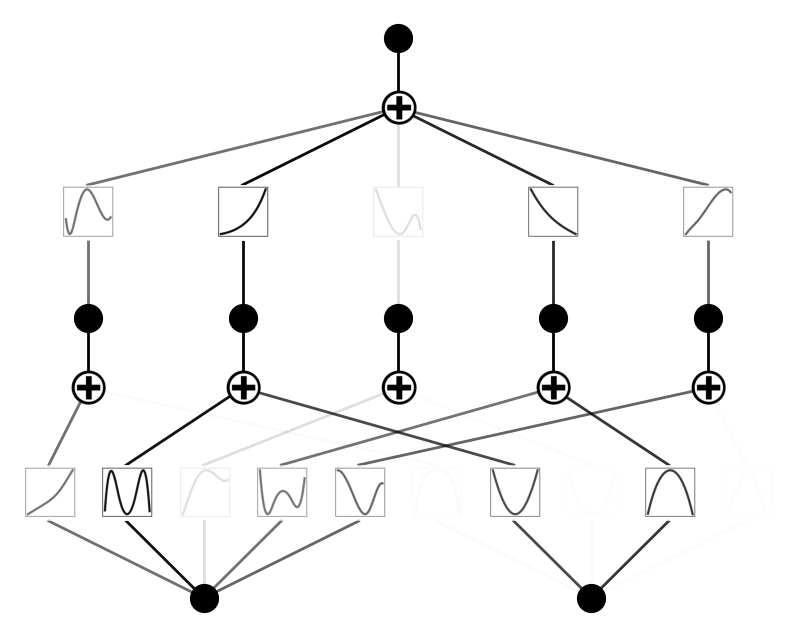

In [54]:
if os.path.exists("kan_test"):
    _ = model.fit(dataset, opt="LBFGS", steps=150)
else:
    _ = model.fit(dataset, opt="LBFGS", steps=150,save_fig=True,img_folder="kan_test")
model.plot(scale=1)


In [5]:
if not os.path.exists("video-1.mp4"): 
    create_video("video-1","kan_test")


Moviepy - Building video video-1.mp4.
Moviepy - Writing video video-1.mp4

5


Moviepy - Done !
Moviepy - video ready video-1.mp4


In [6]:
Video("video-1.mp4", width=640*2, height=480*2)


## Theoretical CheckPoint

 Why some of the lines are darker than others?


#### Simplification techniques

**1.** **Sparsification.** KANs network can adapt the sparsification idea of MLPs to the activation functions. But we need two modifications:
    - There is no linear weight, there are learnable activation functions, so we have to define the L1 Norm of the activation functions.
    - It is possible to show that the sparsification is not sufficient, so we have to add an additional entropy regularization term.

So we define the L1 norm of an activation function $\phi$ over the it's $N_P$ inputs as:
$$ |\phi|_1 = \frac{1}{N_P}\sum_{i=1}^{N_P} |\phi(x_i)|$$

So it's easy to see that the norm of a layer is:
$$ |\Phi|_1 = \sum_{i=1}^{N_{in}}\sum_{j=1}^{N_{out}} |\phi_{i,j}|_1$$

In addition we can define the entropy of $\mathbf{\Phi}$ as:
$$ S(\mathbf{\Phi}) = - \sum_{i=1}^{N_{in}}\sum_{j=1}^{N_{out}} \frac{|\phi_{i,j}|}{|\Phi|_1} \log \left( \frac{|\phi_{i,j}|_1}{|\Phi|_1} \right)$$


**2. Visualization.** We can give a sense of magnitude of the activation function by setting the transparency of $\phi_{l,i,j}$ proportional to $tanh(\beta|\phi_{l,i,j}|_1)$. Hence darker lines are more important.

**3. Pruning.** We can prune the activation functions that are less important by thresholding the L1 norm of the activation functions. for each node we can define and incoming score and an outgoing score by taking the L1 norm of the incoming and outgoing activation functions.

$$ I_{l,i} = \max_{k}\left( |\phi_{l,i,k}|_1\right), \hspace{1cm} O_{l,j} = \max_{k}\left( |\phi_{l+1,j,k}|_1\right). $$

And we consider it important if both are greater the a set hyperparameter $\theta$.



saving model version 0.2


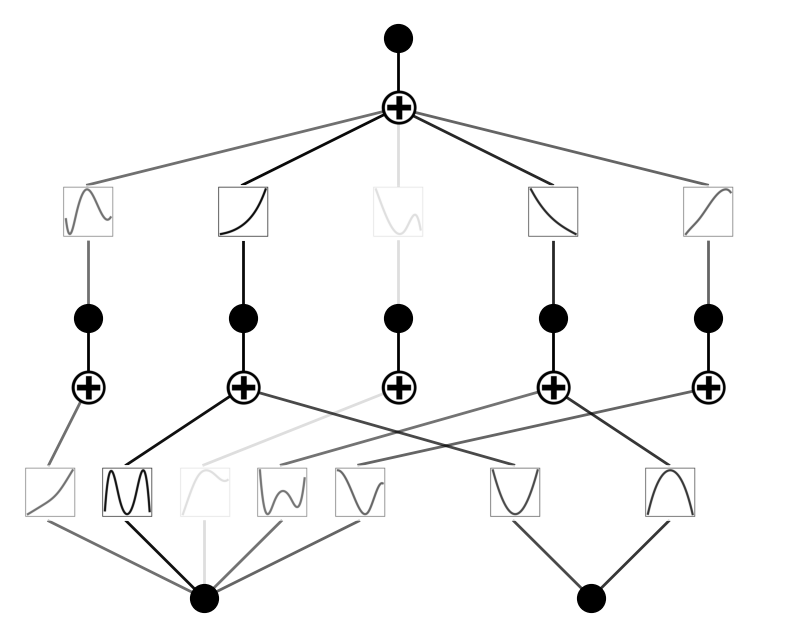

In [55]:
model = model.prune()
model.plot(scale=1)

| train_loss: 4.01e-03 | test_loss: 4.42e-03 | reg: 1.62e+01 | : 100%|█| 100/100 [00:12<00:00,  8.04


saving model version 0.3


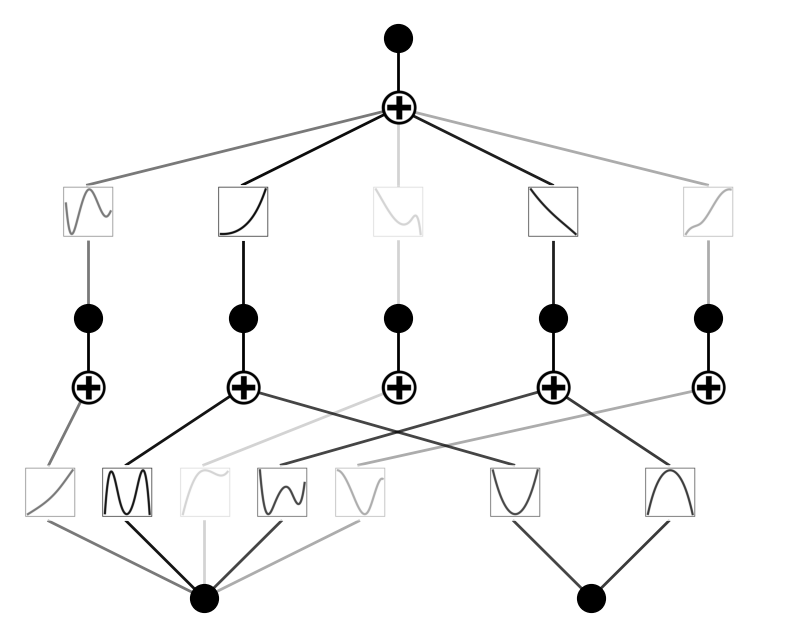

In [56]:
if os.path.exists("kan_test_2"):
    _ = model.fit(dataset, opt="LBFGS", steps=100)
else:
    _ = model.fit(dataset, opt="LBFGS", steps=100,save_fig=True,img_folder="kan_test_2")
model.plot(scale=1)

In [40]:
if not os.path.exists("video-2.mp4"):
    create_video("video-2","kan_test_2")

Video("video-2.mp4", width=640*2, height=480*2)


In [57]:
model = model.refine(10)

saving model version 0.4


| train_loss: 3.74e-04 | test_loss: 4.45e-04 | reg: 1.60e+01 | : 100%|█| 100/100 [00:11<00:00,  8.62


saving model version 0.5


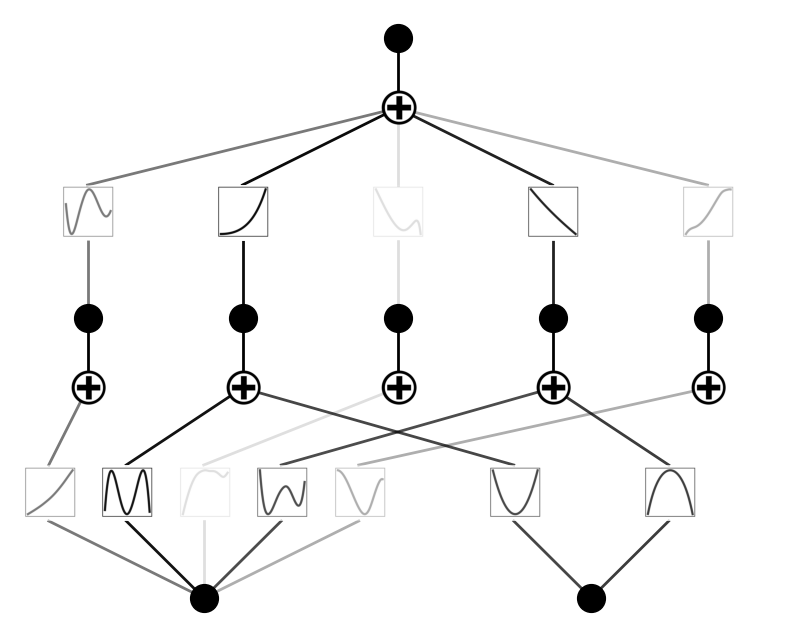

In [58]:
if os.path.exists("kan_test_3"):
    _ = model.fit(dataset, opt="LBFGS")
else:
    _ = model.fit(dataset, opt="LBFGS",save_fig=True,img_folder="kan_test_3")
model.plot(scale=1)

In [43]:
if not os.path.exists("video-3.mp4"):
    create_video("video-3","kan_test_3")

Video("video-3.mp4", width=640*2, height=480*2)


In [59]:
x=dataset['test_input']
y_pred=model(dataset['test_input'])
y_gt=dataset['test_label']
test_loss = nn.MSELoss()(y_pred,y_gt)
y_pred=y_pred.detach().numpy()
y_gt=y_gt.detach().numpy()




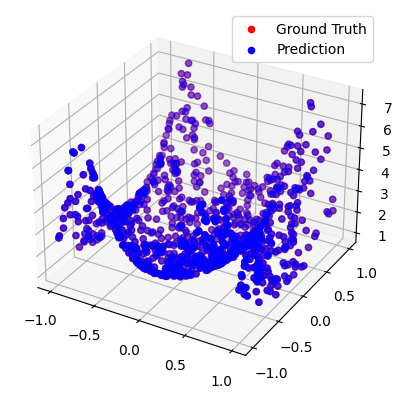

In [60]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],y_gt,color="red",label="Ground Truth")
ax.scatter(x[:,0],x[:,1],y_pred,color="blue",label="Prediction")
plt.legend()
plt.show()


## Let's count how many params we have in the KAN

As we said before the number of parameters is $O(N^2L(G+k)) \approx O(N^2LG)$. In our case we have a KAN defined as [2,5,1].

In [61]:
n_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {n_params}")


Number of parameters: 458


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim

device_mlp = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,n_layers=4):
        super(MLP,self).__init__()
        layers= [nn.Linear(input_dim,hidden_dim)]
        layers.append(nn.ReLU())
        for _ in range(n_layers-1):
            layers.append(nn.Linear(hidden_dim,hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        
        layers.append(nn.Linear(hidden_dim,output_dim))
        self.layers = nn.Sequential(*layers)


    def forward(self,x):
       x=self.layers(x)
       return x
    

mlp_model = MLP(2,128,1,n_layers=5).to(device_mlp)

n_params = sum(p.numel() for p in mlp_model.parameters())
print(f"Number of parameters: {n_params}")


Number of parameters: 66561


In [63]:
x_train=dataset["train_input"]
y_train=dataset["train_label"]
x_test=dataset["test_input"]
y_test=dataset["test_label"]

X_train = torch.tensor(x_train,dtype=torch.float32).to(device_mlp)
y_train = torch.tensor(y_train,dtype=torch.float32).to(device_mlp)
X_test = torch.tensor(x_test,dtype=torch.float32).to(device_mlp)
y_test = torch.tensor(y_test,dtype=torch.float32).to(device_mlp)

optimizer = optim.AdamW(mlp_model.parameters(), lr=0.005)
criterion = nn.MSELoss()


train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)


for epoch in range(2001):
    for batch in train_loader:
        X, y = batch
        optimizer.zero_grad()
        y_pred = mlp_model(X)
        loss = criterion(y_pred,y)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        optimizer.param_groups[0]['lr'] *= 0.9

    if epoch % 100 == 0:
        mlp_model.eval()
        with torch.no_grad():
            for batch in test_loader:
                X, y = batch
                y_pred = mlp_model(X)
                test_loss = criterion(y_pred,y)
                print(f"Epoch {epoch}, Test Loss: {test_loss.item()}")
    if test_loss.item() < 2.61e-04:
        break
        


Epoch 0, Test Loss: 7.166536331176758
Epoch 100, Test Loss: 0.21429266035556793
Epoch 200, Test Loss: 0.003679645946249366
Epoch 300, Test Loss: 0.0026327921077609062
Epoch 400, Test Loss: 0.0043168263509869576
Epoch 500, Test Loss: 0.005496087484061718
Epoch 600, Test Loss: 0.001719229039736092
Epoch 700, Test Loss: 0.0016352233942598104
Epoch 800, Test Loss: 0.0015122485347092152
Epoch 900, Test Loss: 0.0014340797206386924
Epoch 1000, Test Loss: 0.0013697767863050103
Epoch 1100, Test Loss: 0.0013160272501409054
Epoch 1200, Test Loss: 0.0012643838999792933
Epoch 1300, Test Loss: 0.0012253766180947423
Epoch 1400, Test Loss: 0.0011891319882124662
Epoch 1500, Test Loss: 0.001158088562078774
Epoch 1600, Test Loss: 0.0011268900707364082
Epoch 1700, Test Loss: 0.0010957835474982858
Epoch 1800, Test Loss: 0.001072237268090248
Epoch 1900, Test Loss: 0.0010522952070459723
Epoch 2000, Test Loss: 0.0010326312622055411


# Let's use a real dataset


In [80]:
from sklearn.datasets import  make_moons

from kan import *

def get_data(test_split=0.2,random_state=42,device="cpu",is_regression=False):
  #_dataset = load_diabetes()
  _dataset =make_moons(n_samples=10000,noise=0.3)
  print(_dataset[0].shape,_dataset[1].shape)
  y_shape = _dataset[1].shape
  target = _dataset[1]
  if not is_regression:
    if len(y_shape)<2:
      N = len(_dataset[1])
      unique_values = np.unique(_dataset[1])
      unique_dic = {_:i for i,_ in enumerate(unique_values)}
      encoded = np.zeros((N, len(unique_values)), dtype=int)
      for i, value in enumerate(_dataset[1]):
        encoded[i, unique_dic[value]] = 1
      target = encoded

  X_train, X_test, y_train, y_test = train_test_split(_dataset[0],target, test_size=test_split, random_state=random_state)
  mean = X_train.mean(0)
  std =  X_train.std(0)
  ## Normalize the data
  X_train = (X_train - mean)/std
  X_test = (X_test - mean)/std
  dataset ={'train_input':X_train ,'train_label':y_train ,'test_input':X_test ,'test_label':y_test}
  for k,v in dataset.items():
    dataset[k] = torch.tensor(v,dtype=torch.float32).to(device)
  return dataset

In [81]:
dataset_moons = get_data(test_split=0.2,random_state=42,device="cpu")

(10000, 2) (10000,)


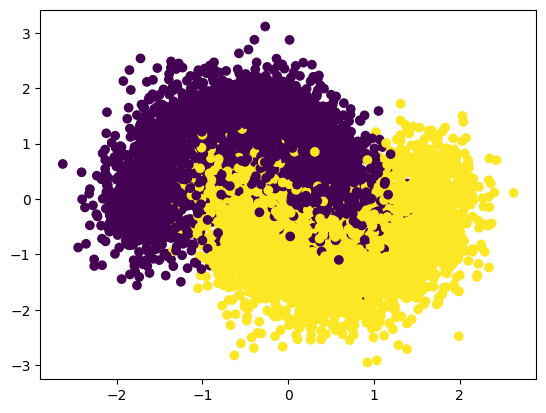

In [82]:
## plot the dataset
plt.scatter(dataset_moons['train_input'][:,0],dataset_moons['train_input'][:,1],c=dataset_moons['train_label'].argmax(1))
plt.show()

In [66]:
model_kan_moons = KAN(width=[2,8,2], grid=3, k=3, seed=0,device="cpu",)
_ = model_kan_moons.fit(dataset_moons, opt="LBFGS", steps=100, lamb=0.01, lamb_entropy=10, lr=0.01,
                loss_fn=torch.nn.CrossEntropyLoss(),batch=1024)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.61e-01 | test_loss: 5.04e-01 | reg: 3.49e+01 | : 100%|█| 100/100 [00:26<00:00,  3.74

saving model version 0.1


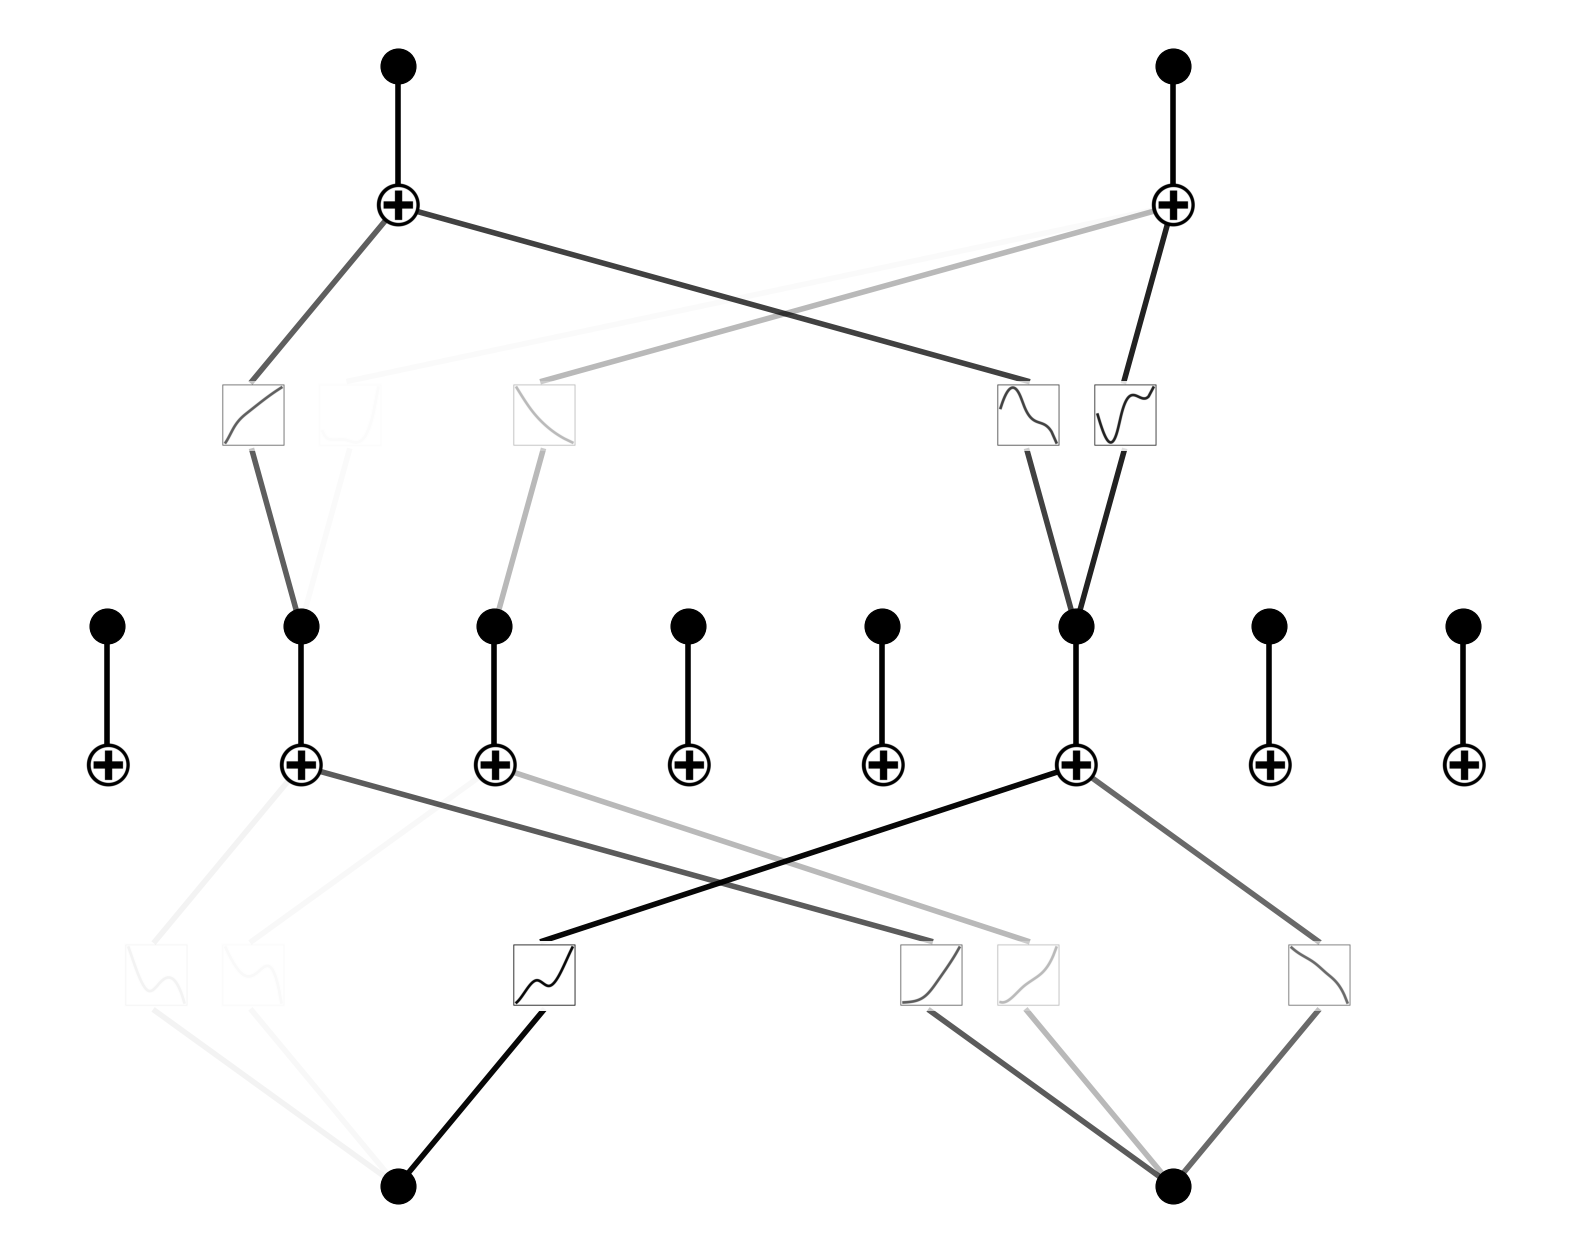

In [21]:
model_kan_moons.plot(scale=1)


In [67]:
model_kan_moonsp = model_kan_moons.prune()


saving model version 0.2


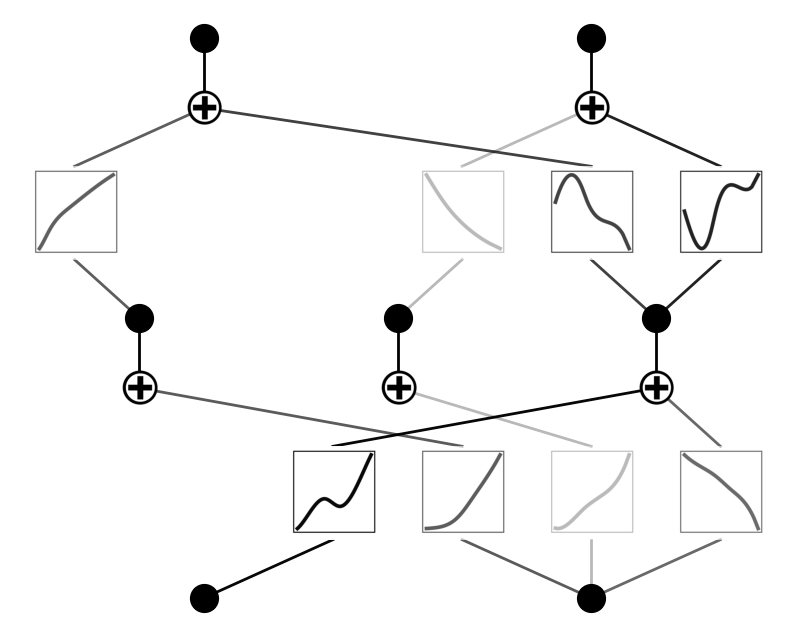

In [68]:
model_kan_moonsp.plot(scale=1)


| train_loss: 4.33e-01 | test_loss: 4.93e-01 | reg: 2.53e+01 | : 100%|█| 20/20 [00:01<00:00, 11.53it


saving model version 0.3


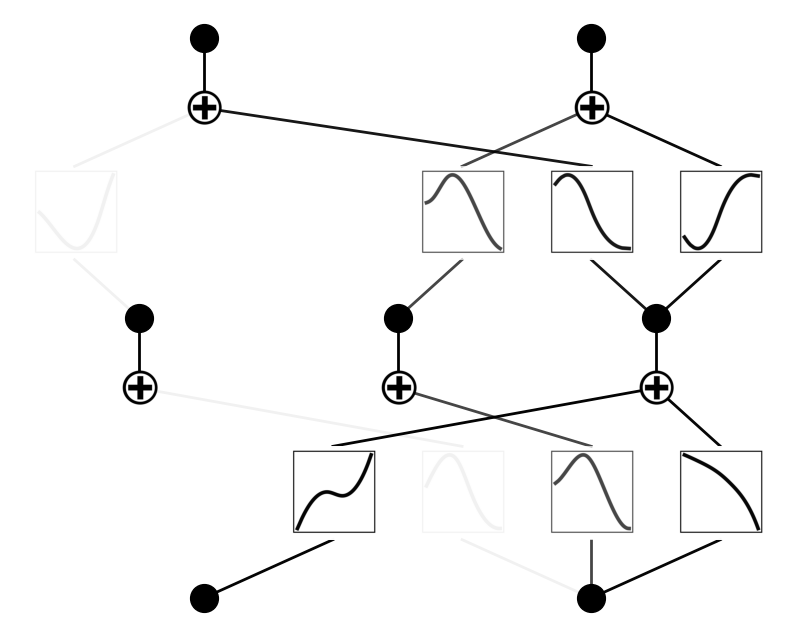

In [69]:
_ = model_kan_moonsp.fit(dataset_moons, opt="LBFGS", steps=20,batch=1024,loss_fn=torch.nn.CrossEntropyLoss())
model_kan_moonsp.plot(scale=1)


In [70]:
model_kan_moonsp=model_kan_moonsp.refine(10)


saving model version 0.4


| train_loss: 4.17e-01 | test_loss: 5.07e-01 | reg: 2.35e+01 | : 100%|█| 40/40 [00:06<00:00,  6.47it


saving model version 0.5


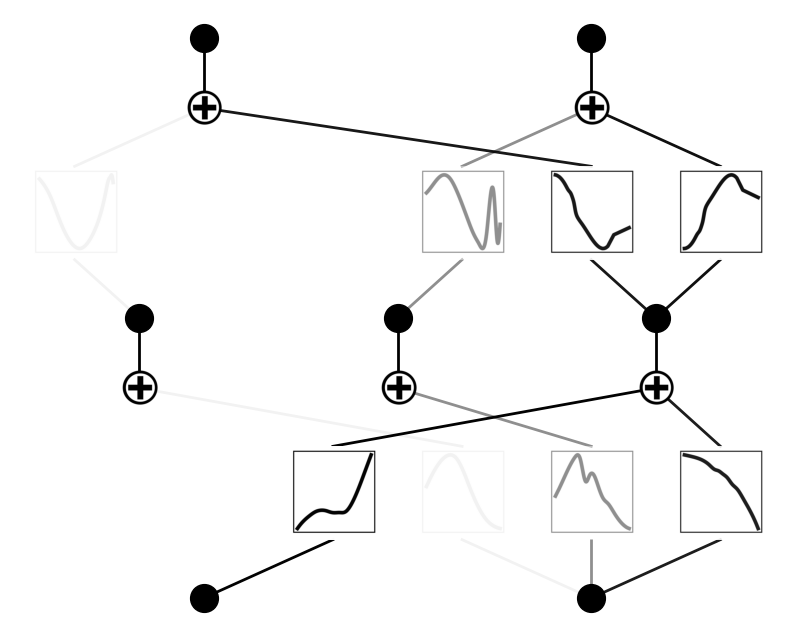

In [71]:
_=model_kan_moonsp.fit(dataset_moons, opt="LBFGS", steps=40,loss_fn=torch.nn.CrossEntropyLoss(),batch=1024)
model_kan_moonsp.plot(scale=1)




tensor([[ 2.3602, -1.7209],
        [-3.2230,  2.7087],
        [ 1.1565, -1.5650],
        [-3.0730,  1.9285],
        [ 1.5331, -0.9060],
        [-2.6621,  3.0984],
        [ 2.4730, -3.4061],
        [-5.0996,  4.3725],
        [ 1.1902, -1.6302],
        [ 3.1846, -4.9885]], grad_fn=<SliceBackward0>)


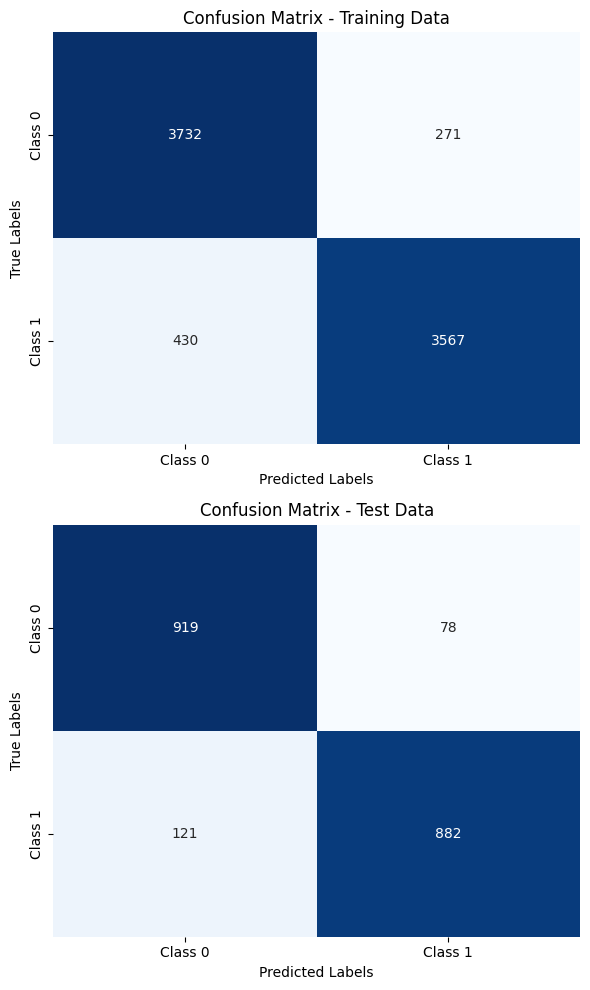

In [72]:
train_true = dataset_moons['train_label'].argmax(1)
train_pred = model_kan_moonsp(dataset_moons['train_input']).cpu().detach().numpy().round().argmax(1)
print(model_kan_moonsp(dataset_moons['train_input'])[0:10])
cm_train = confusion_matrix(train_true, train_pred)

test_true = dataset_moons['test_label'].argmax(1)
test_pred = model_kan_moonsp(dataset_moons['test_input']).cpu().detach().numpy().round().argmax(1)
cm_test = confusion_matrix(test_true, test_pred)


fig, axes = plt.subplots(2, 1, figsize=(6, 10))

plt.subplot(2, 1, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Training Data')

plt.subplot(2, 1, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

In [28]:
## Let's calculate how many parameters we have in the KAN before pruning
n_params = sum(p.numel() for p in model_kan_moons.parameters())
print(f"Number of parameters: {n_params}")


Number of parameters: 588


In [29]:
#Let's calculate how many parameters we have in the KAN pruned
n_params = sum(p.numel() for p in model_kan_moonsp.parameters())
print(f"Number of parameters: {n_params}")


Number of parameters: 357


## Let's compare the performance of the KAN with another MLP

In [73]:
model_moons = MLP(2,1024,1,n_layers=5).to(device_mlp)

In [74]:
X_train = torch.tensor(dataset_moons['train_input'],dtype=torch.float32).to(device_mlp)
y_train = torch.tensor(dataset_moons['train_label'].argmax(1),dtype=torch.float32).to(device_mlp)
X_test = torch.tensor(dataset_moons['test_input'],dtype=torch.float32).to(device_mlp)
y_test = torch.tensor(dataset_moons['test_label'].argmax(1),dtype=torch.float32).to(device_mlp)

train_dataset = torch.utils.data.TensorDataset(X_train,y_train)
test_dataset = torch.utils.data.TensorDataset(X_test,y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)

def train_for_model_breast(model,train_loader,epochs=101,lr=0.0001):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(epochs):
        for batch in train_loader:
            X, y = batch
            optimizer.zero_grad()
            y_pred = model(X).squeeze()
            loss = criterion(y_pred,y)
            loss.backward()
            optimizer.step()
        if epoch % 100 == 0:
            model.eval()
            with torch.no_grad():
                test_loss = 0
                y_pred = model(X_test).squeeze()
                test_loss = criterion(y_pred,y_test)
                print(f"Epoch {epoch}, Test Loss: {test_loss.item()}")

train_for_model_breast(model_moons,train_loader)



Epoch 0, Test Loss: 0.5337303876876831
Epoch 100, Test Loss: 0.2413104772567749


In [75]:
num_params_mlp = sum(p.numel() for p in model_moons.parameters())
print(f"Number of parameters: {num_params_mlp}")



Number of parameters: 4202497


[0 1 0 ... 0 0 1]


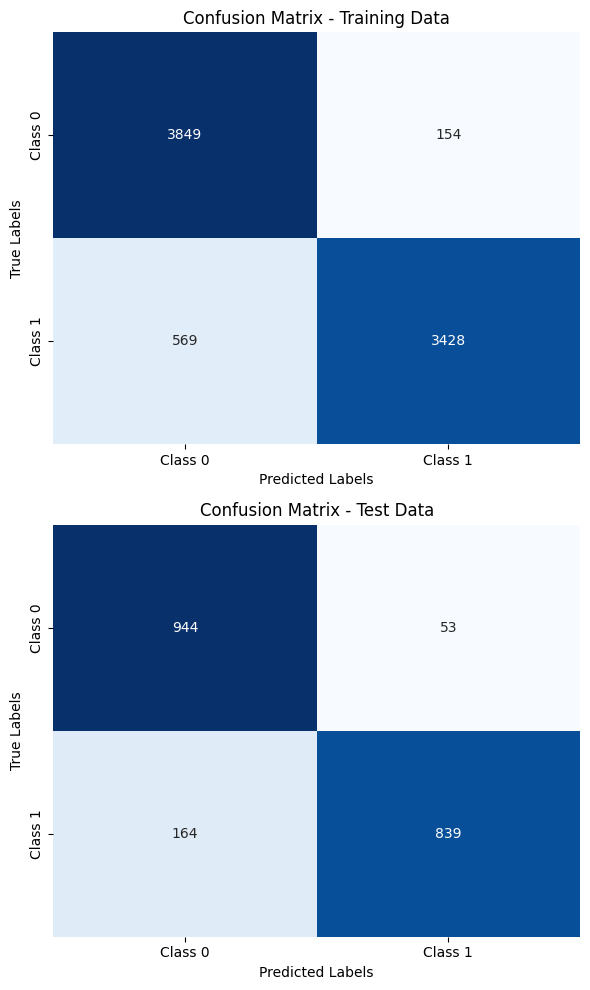

In [33]:
train_true = y_train.cpu().detach().numpy().squeeze()
train_pred = model_moons(X_train).cpu().detach().numpy().round().squeeze()
train_pred = (train_pred>0.5).astype(int)
print(train_pred)
cm_train = confusion_matrix(train_true, train_pred)

test_true = y_test.cpu().detach().numpy().squeeze()
test_pred = model_moons(X_test).cpu().detach().numpy().round().squeeze()
##from 0 to 0.5 is 0 and from 0.5 to 1 is 1
test_pred = (test_pred>0.5).astype(int)
cm_test = confusion_matrix(test_true, test_pred)


fig, axes = plt.subplots(2, 1, figsize=(6, 10))

plt.subplot(2, 1, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Training Data')

plt.subplot(2, 1, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()